In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/121558114.gadi-pbs'

In [3]:


FilePath='/g/data/jk72/deg581/apom/mdl/amery_hr_repeatyear_v11_ctrl/' # Truth file settings
prefix='roms_his_'
timeRange = [12, 13]
datelist = np.array(range(timeRange[0],timeRange[1],1))

def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')



['/g/data/jk72/deg581/apom/mdl/amery_hr_repeatyear_v11_ctrl/roms_his_0012.nc']
255.264537416 G


In [13]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v12_grd.nc')

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r

grd = grd.assign_coords({"x_rho": grd.x_rho})
grd = grd.assign_coords({"y_rho": grd.y_rho})
grd = grd.assign_coords({"lon_rho": grd.lon_rho})
grd = grd.assign_coords({"lat_rho": grd.lat_rho})


grd['mask_zice'] = (grd.mask_rho.where(grd.zice<0)==1) # make a logic mask for ice
grd['mask_zice_nan'] = (grd.mask_rho.where(grd.zice<0)==1).where(grd.mask_rho.where(grd.zice<0)==1) # make a mask where non-ice is nan

In [5]:
# # load single ROMS netcdf with xr
# # ds = xr.open_dataset('../data/proc/roms_v11_TotOptions_his_0003_5daymn.nc')
# ds = xr.open_dataset('../data/proc/roms_v11_ctrl_his_0011-13_5daymn_full.nc')
# ds

In [6]:
# load single ROMS netcdf with xr
# ds = xr.open_dataset('/g/data/jk72/deg581/apom/ana/data/proc/roms_v11_ctrl_dia_0018-19_5daymn_full.nc')
data_set_path = '/g/data/jk72/deg581/apom/mdl/amery_hr_repeatyear_v11_ctrl_diags/roms_dia_0018.nc'
ds = xr.open_dataset(data_set_path)
ds

def loadDataSet(path):
    ds = xr.open_dataset(path)
    return ds

In [7]:
# ds = ds.assign_coords({"x_rho": grd.x_rho})
# ds = ds.assign_coords({"y_rho": grd.y_rho})
# ds = ds.assign_coords({"lon_rho": grd.lon_rho})
# ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# # ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# # ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

# ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice
# ds['mask_zice_nan'] = (ds.mask_rho.where(ds.zice<0)==1).where(ds.mask_rho.where(ds.zice<0)==1) # make a mask where non-ice is nan

In [8]:
# make masks

# now make a ROI mask(s)
# plt.figure(figsize=(6,4))
# ds.mask_zice.plot(x='x_rho',y='y_rho')
# plt.grid()
poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)


mask_roi = inpolygon(grd.x_rho.values, grd.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


grd['mask_zice_roi'] = grd.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
grd.mask_zice_roi.attrs['long_name']=roi_label1

weights = (1/grd.pm)*(1/grd.pn)
weights.name = "weights"

In [ ]:
# print("Vtransform=2")
# #  New formulation (Vtransform(ng) = 2):
# #
# #         z_w(x,y,s,t) = zeta(x,y,t) + [zeta(x,y,t)+ h(x,y)] * Zo_w
# #                 Zo_w = [hc * s(k) + C(k) * h(x,y)] / [hc + h(x,y)]
# hwater = grd.h- abs(grd.zice) # replace ds.h for hwater below
# Zo_rho = (grd.hc * grd.s_rho + grd.Cs_r * hwater) / (grd.hc + hwater)
# z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho 

# Zo_w = (grd.hc * grd.s_w + grd.Cs_w * hwater) / (grd.hc + hwater)
# z_w = ds.zeta + (ds.zeta + hwater) * Zo_w 


# Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
# print(z_w.shape, Z_w.shape)
# dz = np.diff(Z_w,axis=1)

# # dz.load()

In [ ]:
# ds = loadDataSet(data_set_path)
# ds_salt_rate = ds['salt_rate']
# ds_salt_rate.load()
# print('loaded ',ds_salt_rate.nbytes/1e9,'G')

In [9]:
%%time

ds = loadDataSet(data_set_path)
salt_hadv = ds['salt_hadv']
salt_hadv.load()
print('loaded ',salt_hadv.nbytes/1e9,'G')

ds = loadDataSet(data_set_path)
salt_vadv = ds['salt_vadv']
salt_vadv.load()
print('loaded ',salt_vadv.nbytes/1e9,'G')

ds = loadDataSet(data_set_path)
salt_hdiff = ds['salt_hdiff']
salt_hdiff.load()
print('loaded ',salt_hdiff.nbytes/1e9,'G')

ds = loadDataSet(data_set_path)
salt_vdiff = ds['salt_vdiff']
salt_vdiff.load()
print('loaded ',salt_vdiff.nbytes/1e9,'G')

# ds = loadDataSet(data_set_path)
# ds_salt_rate = ds['salt_rate']
# ds_salt_rate.load()
# print('loaded ',ds_salt_rate.nbytes/1e9,'G')

loaded  30.5505 G
loaded  30.5505 G
loaded  30.5505 G
loaded  30.5505 G
CPU times: user 1min 47s, sys: 5min 57s, total: 7min 45s
Wall time: 12min 32s


In [10]:
%%time
ds = loadDataSet(data_set_path)
zeta = ds['zeta']
zeta.load()
print('loaded ',zeta.nbytes/1e9,'G')

loaded  0.9855 G
CPU times: user 1.01 s, sys: 1.99 s, total: 3 s
Wall time: 8.04 s


In [11]:
%%time
hwater = grd.h- abs(grd.zice) # replace ds.h for hwater below
Zo_rho = (grd.hc * grd.s_rho + grd.Cs_r * hwater) / (grd.hc + hwater)
z_rho = zeta + (zeta + hwater) * Zo_rho 

Zo_w = (grd.hc * grd.s_w + grd.Cs_w * hwater) / (grd.hc + hwater)
z_w = zeta + (zeta + hwater) * Zo_w 


Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
print(z_w.shape, Z_w.shape)
dz = np.diff(Z_w,axis=1)

(365, 750, 900, 32) (365, 32, 750, 900)
CPU times: user 1min 5s, sys: 4min 8s, total: 5min 13s
Wall time: 5min 52s


In [ ]:
%%time 

salt_hadv_dz = salt_hadv*dz

salt_vadv_dz = salt_vadv*dz

salt_hdiff_dz = salt_hdiff*dz

salt_vdiff_dz = salt_vdiff*dz


In [ ]:
# ds = ds.drop_vars(['temp_xadv','temp_yadv','temp_xdiff','temp_ydiff','salt_xadv','salt_yadv','salt_xdiff','salt_ydiff','temp_sdiff','salt_sdiff'])
# ds = ds.drop_vars(['temp_rate','temp_hadv','temp_vadv','temp_hdiff','temp_vdiff','zeta'])
# print(ds.nbytes/1e9,'G')
# ds

In [ ]:
# # chop in time, selecting a smaller segment
# ds = ds.sel(ocean_time=slice('2023-01-01','2025-01-01'))

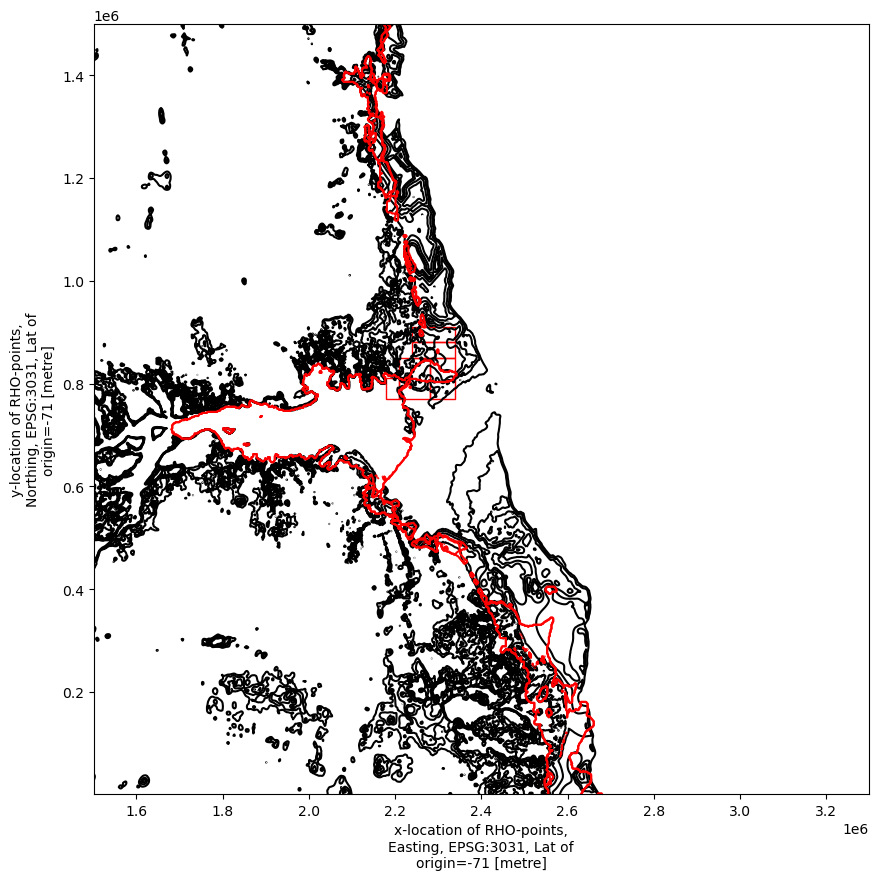

In [14]:
from matplotlib.patches import Rectangle

#%matplotlib widget

plt.figure(figsize=(10,10)),
# ds.my_doy.mean(dim='dayofyear').plot(x='x_rho',y='y_rho',cmap='RdBu',vmin=0,vmax=10)
grd.h.plot.contour(x='x_rho',y='y_rho',levels=(0,100,200,300,400,500),colors='k')
(-1*grd.zice*grd.mask_rho).plot.contour(x='x_rho',y='y_rho',levels=(0,1),colors='r')

pnt_bl=(2.21e6,.77e6)
pnt_tr=(2.28e6,.85e6)

plt.gca().add_patch(Rectangle(pnt_bl,pnt_tr[0]-pnt_bl[0],pnt_tr[1]-pnt_bl[1],linewidth=1,edgecolor='r',facecolor='none'))

pnt_bl=(2.28e6,.77e6)
pnt_tr=(2.34e6,.85e6)

plt.gca().add_patch(Rectangle(pnt_bl,pnt_tr[0]-pnt_bl[0],pnt_tr[1]-pnt_bl[1],linewidth=1,edgecolor='r',facecolor='none'))

pnt_bl=(2.24e6,.85e6)
pnt_tr=(2.34e6,.88e6)

plt.gca().add_patch(Rectangle(pnt_bl,pnt_tr[0]-pnt_bl[0],pnt_tr[1]-pnt_bl[1],linewidth=1,edgecolor='r',facecolor='none'))

pnt_bl=(2.24e6,.88e6)
pnt_tr=(2.34e6,.91e6)

plt.gca().add_patch(Rectangle(pnt_bl,pnt_tr[0]-pnt_bl[0],pnt_tr[1]-pnt_bl[1],linewidth=1,edgecolor='r',facecolor='none'))



pnt_bl=(2.18e6,.77e6)
pnt_tr=(2.21e6,.81e6)

plt.gca().add_patch(Rectangle(pnt_bl,pnt_tr[0]-pnt_bl[0],pnt_tr[1]-pnt_bl[1],linewidth=1,edgecolor='r',facecolor='none'))




%matplotlib inline

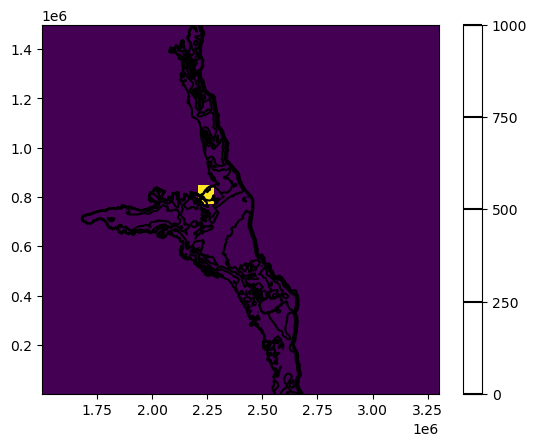

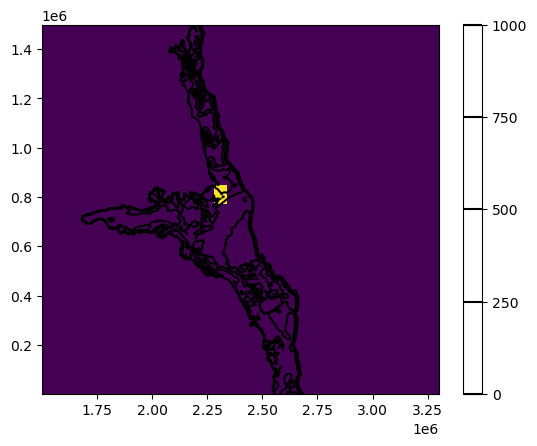

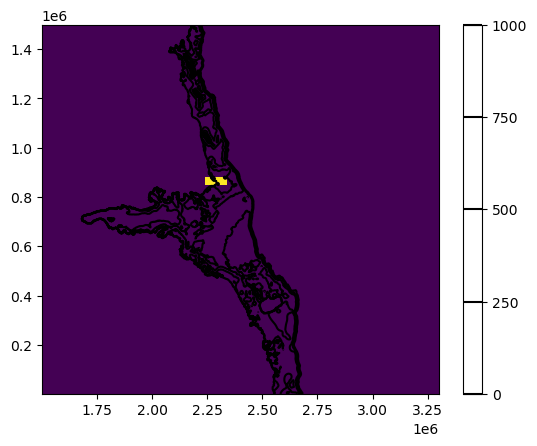

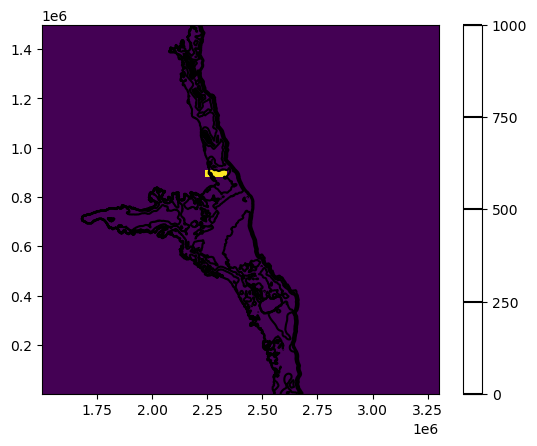

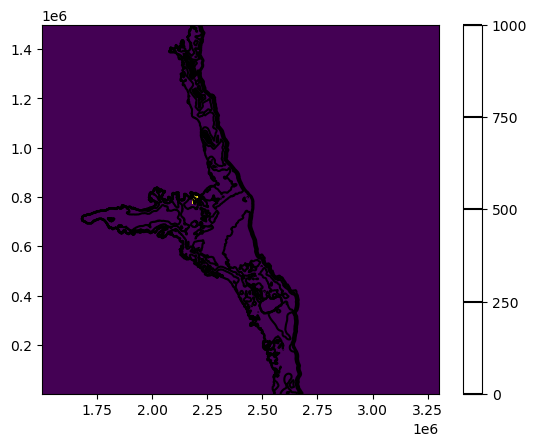

In [16]:
# make masks for salt box

pnt_bl=(2.21e6,.77e6)
pnt_tr=(2.28e6,.85e6)


# make a mask for where we want to include in the average
mask_mac = np.zeros_like(grd.lon_rho)
mask_mac[(grd.x_rho > pnt_bl[0]) & (grd.x_rho < pnt_tr[0]) & (grd.y_rho > pnt_bl[1]) & (grd.y_rho < pnt_tr[1])]=1

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_mac)
plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000),colors='k')
plt.colorbar()
plt.show()



pnt_bl=(2.28e6,.77e6)
pnt_tr=(2.34e6,.85e6)


# make a mask for where we want to include in the average
mask_cdit = np.zeros_like(grd.lon_rho)
mask_cdit[(grd.x_rho > pnt_bl[0]) & (grd.x_rho < pnt_tr[0]) & (grd.y_rho > pnt_bl[1]) & (grd.y_rho < pnt_tr[1])]=1

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_cdit)
plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000),colors='k')
plt.colorbar()
plt.show()



pnt_bl=(2.24e6,.85e6)
pnt_tr=(2.34e6,.88e6)


# make a mask for where we want to include in the average
mask_cdpe = np.zeros_like(grd.lon_rho)
mask_cdpe[(grd.x_rho > pnt_bl[0]) & (grd.x_rho < pnt_tr[0]) & (grd.y_rho > pnt_bl[1]) & (grd.y_rho < pnt_tr[1])]=1

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_cdpe)
plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000),colors='k')
plt.colorbar()
plt.show()


pnt_bl=(2.24e6,.88e6)
pnt_tr=(2.34e6,.91e6)


# make a mask for where we want to include in the average
mask_cdpw = np.zeros_like(grd.lon_rho)
mask_cdpw[(grd.x_rho > pnt_bl[0]) & (grd.x_rho < pnt_tr[0]) & (grd.y_rho > pnt_bl[1]) & (grd.y_rho < pnt_tr[1])]=1

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_cdpw)
plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000),colors='k')
plt.colorbar()
plt.show()



pnt_bl=(2.18e6,.77e6)
pnt_tr=(2.21e6,.81e6)


# make a mask for where we want to include in the average
mask_aiso = np.zeros_like(grd.lon_rho)
mask_aiso[(grd.x_rho > pnt_bl[0]) & (grd.x_rho < pnt_tr[0]) & (grd.y_rho > pnt_bl[1]) & (grd.y_rho < pnt_tr[1])]=1

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_aiso)
plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000),colors='k')
plt.colorbar()
plt.show()



In [17]:
# ds_salt_rate.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
(salt_hadv+salt_vadv+salt_hdiff+salt_vdiff).isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()

KeyboardInterrupt: 

In [ ]:
(salt_hadv).isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_vadv.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_hdiff.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_vdiff.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()

In [ ]:
salt_hdiff.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_vdiff.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()

In [ ]:
salt_vdiff.sum(dim='s_rho').mean(dim='ocean_time').plot()

In [ ]:
ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/mdl/amery_hr_repeatyear_v11_ctrl_diags/roms_his_0018.nc')
ssflux = ds_his["ssflux"] 
ds_his.close()

In [ ]:
ssflux.mean(dim='ocean_time').plot()

In [ ]:
# now correctly weight them

In [ ]:
%%time 

salt_hadv_dz = salt_hadv*dz

salt_vadv_dz = salt_vadv*dz

salt_hdiff_dz = salt_hdiff*dz

salt_vdiff_dz = salt_vdiff*dz


In [ ]:
(salt_hadv_dz).isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_vadv_dz.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_hdiff_dz.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()
salt_vdiff_dz.isel(xi_rho=362,eta_rho=391).sum(dim='s_rho').plot()

In [ ]:
salt_vdiff_dz.sum(dim='s_rho').mean(dim='ocean_time').plot()

In [ ]:
ds.salt

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_mac==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            [-1.95],colors='C1',linestyles='-')

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdit==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            [-1.95],colors='C1',linestyles='-')

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpe==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            [-1.95],colors='C1',linestyles='-')

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
im=plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)


plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')
cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'salinity')

ax=fig.add_subplot(gs[1,0])
im=plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)


plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            [-1.95],colors='C1',linestyles='-')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'pot temp')

ax=fig.add_subplot(gs[2,0])
plt.plot(ds.ocean_time,ds.shflux.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),'C1')
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim((-200,200))
ax2 = ax.twinx()
ax2.plot(ds.ocean_time,ds.ssflux.where(mask_cdpw==1).weighted(weights).mean(('xi_rho','eta_rho')),'C0')
ax2.autoscale(enable=True, axis='x', tight=True)
# ax2.set_ylim((-2,2))

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax=fig.add_subplot(gs[0,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.salt.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')

ax=fig.add_subplot(gs[1,0])
plt.pcolormesh(ds.ocean_time,ds.z_rho0.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)
plt.colorbar()
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),
               ds.temp.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')).T,
            [-1.95],colors='C1',linestyles='-')

ax=fig.add_subplot(gs[2,0])
plt.plot(ds.ocean_time,ds.shflux.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),'C1')
plt.plot(ds.ocean_time,ds.ssflux.where(mask_aiso==1).weighted(weights).mean(('xi_rho','eta_rho')),'C0')

In [ ]:
# test sum salt in one of the boxes

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None


where_x=390
where_e=440

ax=fig.add_subplot(gs[0,0])
im=plt.pcolormesh(ds.ocean_time,ds.z_rho0.isel(xi_rho=where_x,eta_rho=where_e),
               ds.salt.isel(xi_rho=where_x,eta_rho=where_e).T,shading='gouraud',
              cmap='cmo.haline',vmin=34,vmax=35)


plt.contour(ds.ocean_time,ds.z_rho0.isel(xi_rho=where_x,eta_rho=where_e),
               ds.salt.isel(xi_rho=where_x,eta_rho=where_e).T,
            levels=np.arange(34.0,35.0,0.05),colors='k')
cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'salinity')

ax=fig.add_subplot(gs[1,0])
im=plt.pcolormesh(ds.ocean_time,ds.z_rho0.isel(xi_rho=where_x,eta_rho=where_e),
               ds.temp.isel(xi_rho=where_x,eta_rho=where_e).T,shading='gouraud',
              cmap='cmo.thermal',vmin=-2.5,vmax=0)


plt.contour(ds.ocean_time,ds.z_rho0.isel(xi_rho=where_x,eta_rho=where_e),
               ds.temp.isel(xi_rho=where_x,eta_rho=where_e).T,
            levels=np.arange(-2.5,0,0.1),colors='k',linestyles='-')
plt.contour(ds.ocean_time,ds.z_rho0.isel(xi_rho=where_x,eta_rho=where_e),
               ds.temp.isel(xi_rho=where_x,eta_rho=where_e).T,
            [-1.95],colors='C1',linestyles='-')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.25, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'pot temp')

ax=fig.add_subplot(gs[2,0])
plt.plot(ds.ocean_time,ds.shflux.isel(xi_rho=where_x,eta_rho=where_e),'C1')
ax.autoscale(enable=True, axis='x', tight=True)
ax.set_ylim((-400,200))
ax2 = ax.twinx()
ax2.plot(ds.ocean_time,-ds.ssflux.isel(xi_rho=where_x,eta_rho=where_e),'C0')
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.set_ylim((-4*1e-5,2*1e-5))

In [ ]:
# now make those poster plots again

In [ ]:
# now look at heat coming onto shelf
target_depth = -400

temp400 = grid.transform(ds.temp, 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# salt400_FM = grid.transform(ds.salt, 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()

temp400_clima = temp400.groupby('ocean_time.dayofyear').mean()

In [ ]:
from scipy.ndimage import gaussian_filter1d


temp400.isel(ocean_time=slice(25,85)).mean(dim='ocean_time').plot(vmin=-2,vmax=-.5)
co1 = plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co10 = plt.contour(ds.h*ds.mask_rho,levels=(0,1),colors='k',linestyles='-',linewidths=0.5)
co2 = plt.contour(ds.h*ds.mask_rho,levels=(250,500,750,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.axis((325,475,225,450))
plt.plot(450,335,'x',color='C1')
plt.plot(408,262,'x',color='C2')
plt.show()

plt.plot(ds.ocean_time,temp400.isel(xi_rho=450,eta_rho=335),color='C1',linewidth=.5,label='400m temp - outer shelf')
plt.plot(ds.ocean_time,gaussian_filter1d(temp400.isel(xi_rho=450,eta_rho=335), 5),color='C1',linewidth=2.5,label='400m temp - outer shelf (5-day filter)')
plt.plot(ds.ocean_time,temp400.isel(xi_rho=408,eta_rho=262),color='C2',linewidth=.5,label='400m temp - coast')
plt.plot(ds.ocean_time,gaussian_filter1d(temp400.isel(xi_rho=408,eta_rho=262), 5),color='C2',linewidth=2.5,label='400m temp - coast (5-day filter)')
plt.show()



In [ ]:
image_save_dpi = 1000

# # plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(temp400_clima.dayofyear,temp400_clima.isel(xi_rho=450,eta_rho=335),color='C1',linewidth=1.5)#,label='400m temp - outer shelf')
ax.plot(temp400_clima.dayofyear,gaussian_filter1d(temp400_clima.isel(xi_rho=450,eta_rho=335), 5),color='C1',linewidth=5,label='400m temp @ outer shelf')
ax.plot(temp400_clima.dayofyear,temp400_clima.isel(xi_rho=408,eta_rho=262),color='lightcoral',linewidth=1.5)#,label='400m temp - coast')
ax.plot(temp400_clima.dayofyear,gaussian_filter1d(temp400_clima.isel(xi_rho=408,eta_rho=262), 5),color='lightcoral',linewidth=5,label='400m temp @ coast')



# ax.annotate("400m temp @ outer shelf",
#             xy=(250,-1), xycoords='data',
#             xytext=(250,-1), textcoords='data',
#             size=40, va="center", ha="center",
#             bbox=dict(boxstyle="round4", fc="w", alpha=0.75))

# # plt.rcParams.update({'font.size': 16})
# # plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'Temperature ($\theta$ $^\circ$C)')
ax.set_xlabel('day of year')
# ax.grid()
ax.legend(frameon=False,loc='upper right')
ax.set_title('')

In [ ]:
# now melt rate variability
ds['m'] = ds.m.where(ds.m<1e35,np.NaN)
ds['my'] = ds.m*(60*60*24*365)
# ds.my.mean(dim='ocean_time').where(ds.zice<-500).plot(vmin=-10,vmax=10)
# time evolution of melt rate

ds['my_doy'] = ds.my.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0',linewidth=1.5)#,label='mean melt (zice<500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C0',linewidth=5,label='mean melt')
(ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=1.5)#,label='mean melt (zice>500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C1',linewidth=5,label='mean melt (zice>500m)')

# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'melt rate (m/yr)')
ax.set_xlabel('day of year')
# ax.grid()
ax.legend(frameon=False,loc='lower left')
ax.set_title('')


In [ ]:
(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).mean(dim='dayofyear')


In [ ]:
# isw plume strength
import seawater as sw

sigma_0_surf = sw.pden(ds.salt.isel(s_rho=-1).values,sw.temp(ds.salt.isel(s_rho=-1).values,ds.temp.isel(s_rho=-1).values,ds.z_rho0.isel(s_rho=-1).values),ds.z_rho0.isel(s_rho=-1).values,0)-1000
ds['sigma_0_surf']=(('ocean_time','eta_rho','xi_rho'),sigma_0_surf)


mask = np.zeros_like(ds.lon_rho)
mask[380:386,318:323]=1


ds['sigma_0_surf_clima'] = ds.sigma_0_surf.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')


(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='orangered',linewidth=1.5)#,label='mean melt (zice<500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='orangered',linewidth=5,label='AIS mean melt')
# (ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=.5)#,label='mean melt (zice>500m)')
# plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C1',linewidth=2,label='mean melt (zice>500m)')


ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('sin')#, color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

ax2.plot(ds.dayofyear,ds.sigma_0_surf_clima.where(mask==1).weighted(weights_area).mean(('eta_rho','xi_rho')),color='skyblue',linewidth=1.5)
ax2.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_surf_clima.where(mask==1).weighted(weights_area).mean(('eta_rho','xi_rho')),2),color='skyblue',linewidth=5,label='$\sigma_0$ @ outflow')
ax2.set_ylabel('surface $\sigma_0$ anomay (kg/m$^3$)')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'melt rate (m/yr)')
ax.set_xlabel('day of year')
# ax.grid()

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False,loc='lower left')

# ax.legend(frameon=False,loc='lower left')
ax.set_title('')



In [ ]:
frc = xr.open_dataset('../../frc/amery_v2km_tamura+era_shflux.nc')



In [ ]:


# make heat flux plot
(frc.shflux*ds.mask_rho*~ds.mask_zice).mean(dim='shf_time').plot(levels=12)
co1 = plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co10 = plt.contour(ds.h*ds.mask_rho,levels=(0,1),colors='k',linestyles='-',linewidths=0.5)
co2 = plt.contour(ds.h*ds.mask_rho,levels=(250,500,750,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.axis((300,450,350,600))
plt.plot(390,440,'x',color='C1')
plt.plot(362,391,'x',color='C2')

plt.show()

plt.plot(frc.shf_time,frc.shflux.isel(xi_rho=390,eta_rho=440),color='C1',linewidth=.5,label='shflux - CD')
plt.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=390,eta_rho=440), 5),color='C1',linewidth=2.5,label='shflux - CD (5-day filter)')
plt.plot(frc.shf_time,frc.shflux.isel(xi_rho=362,eta_rho=391),color='C2',linewidth=.5,label='shflux - Ma')
plt.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=362,eta_rho=391), 5),color='C2',linewidth=2.5,label='shflux - Ma (5-day filter)')


In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(frc.shf_time,frc.shflux.isel(xi_rho=362,eta_rho=391),color='C2',linewidth=1.5)#,label='shflux - Ma')
ax.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=362,eta_rho=391), 5),color='C2',linewidth=5,label='Mackenzie polynya')
ax.plot(frc.shf_time,frc.shflux.isel(xi_rho=390,eta_rho=440),color='steelblue',linewidth=1.5)#,label='shflux - CD')
ax.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=390,eta_rho=440), 5),color='steelblue',linewidth=5,label='Cape Darnley')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'surface heat flux (W/m$^2$)')
ax.set_xlabel('day of year')
# ax.grid()

ax.legend(frameon=False,loc='lower left')
ax.set_title('')



In [ ]:
# make bottom density 
sigma_0_bot = sw.pden(ds.salt.isel(s_rho=0).values,sw.temp(ds.salt.isel(s_rho=0).values,ds.temp.isel(s_rho=0).values,ds.z_rho0.isel(s_rho=0).values),ds.z_rho0.isel(s_rho=0).values,0)-1000
ds['sigma_0_bot']=(('ocean_time','eta_rho','xi_rho'),sigma_0_bot)


ds['sigma_0_bot_clima'] = ds.sigma_0_bot.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])



# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(ds.dayofyear,ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=440),color='steelblue',linewidth=1.5)
ax.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=440), 2),color='steelblue',linewidth=5,label='bottom $\sigma_0$ - Cape Darnley')
# ax.plot(ds.dayofyear,ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=462),color='C4',linewidth=.5)
# ax.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=462), 2),color='C4',linewidth=2.5,label='bottom $\sigma_0$ - Burton basin')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('bottom $\sigma_0$ anomaly (kg/m$^3$)')
ax.set_xlabel('day of year')
# ax.grid()

ax.legend(frameon=False,loc='upper left')
ax.set_title('')





In [ ]:
STOP

In [ ]:
# now look at heat coming onto shelf
target_depth = -400

temp400 = grid.transform(ds.temp, 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()
# salt400_FM = grid.transform(ds.salt, 'Z', np.array([target_depth]),target_data=ds.z_rho0,method='linear').squeeze()

temp400_clima = temp400.groupby('ocean_time.dayofyear').mean()

In [ ]:
from scipy.ndimage import gaussian_filter1d


temp400.isel(ocean_time=slice(25,85)).mean(dim='ocean_time').plot(vmin=-2,vmax=-.5)
co1 = plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co10 = plt.contour(ds.h*ds.mask_rho,levels=(0,1),colors='k',linestyles='-',linewidths=0.5)
co2 = plt.contour(ds.h*ds.mask_rho,levels=(250,500,750,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.axis((325,475,225,450))
plt.plot(450,335,'x',color='C1')
plt.plot(408,262,'x',color='C2')
plt.show()

plt.plot(ds.ocean_time,temp400.isel(xi_rho=450,eta_rho=335),color='C1',linewidth=.5,label='400m temp - outer shelf')
plt.plot(ds.ocean_time,gaussian_filter1d(temp400.isel(xi_rho=450,eta_rho=335), 5),color='C1',linewidth=2.5,label='400m temp - outer shelf (5-day filter)')
plt.plot(ds.ocean_time,temp400.isel(xi_rho=408,eta_rho=262),color='C2',linewidth=.5,label='400m temp - coast')
plt.plot(ds.ocean_time,gaussian_filter1d(temp400.isel(xi_rho=408,eta_rho=262), 5),color='C2',linewidth=2.5,label='400m temp - coast (5-day filter)')
plt.show()



In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(temp400_clima.dayofyear,temp400_clima.isel(xi_rho=450,eta_rho=335),color='C1',linewidth=1.5)#,label='400m temp - outer shelf')
ax.plot(temp400_clima.dayofyear,gaussian_filter1d(temp400_clima.isel(xi_rho=450,eta_rho=335), 5),color='C1',linewidth=5,label='400m temp @ outer shelf')
ax.plot(temp400_clima.dayofyear,temp400_clima.isel(xi_rho=408,eta_rho=262),color='lightcoral',linewidth=1.5)#,label='400m temp - coast')
ax.plot(temp400_clima.dayofyear,gaussian_filter1d(temp400_clima.isel(xi_rho=408,eta_rho=262), 5),color='lightcoral',linewidth=5,label='400m temp @ coast')



# ax.annotate("400m temp @ outer shelf",
#             xy=(250,-1), xycoords='data',
#             xytext=(250,-1), textcoords='data',
#             size=40, va="center", ha="center",
#             bbox=dict(boxstyle="round4", fc="w", alpha=0.75))

# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'Temperature ($\theta$ $^\circ$C)')
ax.set_xlabel('day of year')
# ax.grid()
ax.legend(frameon=False,loc='upper right')
ax.set_title('')

In [ ]:
# now melt rate variability
ds['m'] = ds.m.where(ds.m<1e35,np.NaN)
ds['my'] = ds.m*(60*60*24*365)
# ds.my.mean(dim='ocean_time').where(ds.zice<-500).plot(vmin=-10,vmax=10)
# time evolution of melt rate

ds['my_doy'] = ds.my.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C0',linewidth=1.5)#,label='mean melt (zice<500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C0',linewidth=5,label='mean melt')
(ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=1.5)#,label='mean melt (zice>500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C1',linewidth=5,label='mean melt (zice>500m)')

# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'melt rate (m/yr)')
ax.set_xlabel('day of year')
# ax.grid()
ax.legend(frameon=False,loc='lower left')
ax.set_title('')


In [ ]:
(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).mean(dim='dayofyear')


In [ ]:
# isw plume strength
import seawater as sw

sigma_0_surf = sw.pden(ds.salt.isel(s_rho=-1).values,sw.temp(ds.salt.isel(s_rho=-1).values,ds.temp.isel(s_rho=-1).values,ds.z_rho0.isel(s_rho=-1).values),ds.z_rho0.isel(s_rho=-1).values,0)-1000
ds['sigma_0_surf']=(('ocean_time','eta_rho','xi_rho'),sigma_0_surf)


mask = np.zeros_like(ds.lon_rho)
mask[380:386,318:323]=1


ds['sigma_0_surf_clima'] = ds.sigma_0_surf.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')


(ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='orangered',linewidth=1.5)#,label='mean melt (zice<500m)')
plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='orangered',linewidth=5,label='AIS mean melt')
# (ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')).plot(color='C1',linewidth=.5)#,label='mean melt (zice>500m)')
# plt.plot(ds.dayofyear,gaussian_filter1d((ds.my_doy*ds.mask_zice_roi.where(ds.zice>-500).where(ds.mask_zice_roi,np.NaN)).weighted(weights_area).mean(('eta_rho','xi_rho')), 5),color='C1',linewidth=2,label='mean melt (zice>500m)')


ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('sin')#, color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

ax2.plot(ds.dayofyear,ds.sigma_0_surf_clima.where(mask==1).weighted(weights_area).mean(('eta_rho','xi_rho')),color='skyblue',linewidth=1.5)
ax2.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_surf_clima.where(mask==1).weighted(weights_area).mean(('eta_rho','xi_rho')),2),color='skyblue',linewidth=5,label='$\sigma_0$ @ outflow')
ax2.set_ylabel('surface $\sigma_0$ anomay (kg/m$^3$)')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'melt rate (m/yr)')
ax.set_xlabel('day of year')
# ax.grid()

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,frameon=False,loc='lower left')

# ax.legend(frameon=False,loc='lower left')
ax.set_title('')



In [ ]:
frc = xr.open_dataset('../../frc/amery_v2km_tamura+era_shflux.nc')



In [ ]:


# make heat flux plot
(frc.shflux*ds.mask_rho*~ds.mask_zice).mean(dim='shf_time').plot(levels=12)
co1 = plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C2',linestyles='-',linewidths=1)
co10 = plt.contour(ds.h*ds.mask_rho,levels=(0,1),colors='k',linestyles='-',linewidths=0.5)
co2 = plt.contour(ds.h*ds.mask_rho,levels=(250,500,750,1000,2000),colors='k',linestyles='-',linewidths=0.5)
plt.axis((300,450,350,600))
plt.plot(390,440,'x',color='C1')
plt.plot(362,391,'x',color='C2')

plt.show()

plt.plot(frc.shf_time,frc.shflux.isel(xi_rho=390,eta_rho=440),color='C1',linewidth=.5,label='shflux - CD')
plt.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=390,eta_rho=440), 5),color='C1',linewidth=2.5,label='shflux - CD (5-day filter)')
plt.plot(frc.shf_time,frc.shflux.isel(xi_rho=362,eta_rho=391),color='C2',linewidth=.5,label='shflux - Ma')
plt.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=362,eta_rho=391), 5),color='C2',linewidth=2.5,label='shflux - Ma (5-day filter)')


In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])


# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(frc.shf_time,frc.shflux.isel(xi_rho=362,eta_rho=391),color='C2',linewidth=1.5)#,label='shflux - Ma')
ax.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=362,eta_rho=391), 5),color='C2',linewidth=5,label='Mackenzie polynya')
ax.plot(frc.shf_time,frc.shflux.isel(xi_rho=390,eta_rho=440),color='steelblue',linewidth=1.5)#,label='shflux - CD')
ax.plot(frc.shf_time,gaussian_filter1d(frc.shflux.isel(xi_rho=390,eta_rho=440), 5),color='steelblue',linewidth=5,label='Cape Darnley')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel(r'surface heat flux (W/m$^2$)')
ax.set_xlabel('day of year')
# ax.grid()

ax.legend(frameon=False,loc='lower left')
ax.set_title('')



In [ ]:
# make bottom density 
sigma_0_bot = sw.pden(ds.salt.isel(s_rho=0).values,sw.temp(ds.salt.isel(s_rho=0).values,ds.temp.isel(s_rho=0).values,ds.z_rho0.isel(s_rho=0).values),ds.z_rho0.isel(s_rho=0).values,0)-1000
ds['sigma_0_bot']=(('ocean_time','eta_rho','xi_rho'),sigma_0_bot)


ds['sigma_0_bot_clima'] = ds.sigma_0_bot.groupby('ocean_time.dayofyear').mean()

In [ ]:
image_save_dpi = 1000

# plt.rcParams['figure.dpi'] = image_save_dpi

gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])



# ax.axvline((32),color='0.9')
# ax.axvline((60),color='0.9')
ax.axvline((91),color='0.9') #apr
# ax.axvline((121),color='0.9')
# ax.axvline((152),color='0.9')
ax.axvline((182),color='0.9') #july
# ax.axvline((213),color='0.9')
# ax.axvline((244),color='0.9')
ax.axvline((274),color='0.9') #oct
# ax.axvline((305),color='0.9')
# ax.axvline((335),color='0.9')

ax.plot(ds.dayofyear,ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=440),color='steelblue',linewidth=1.5)
ax.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=440), 2),color='steelblue',linewidth=5,label='bottom $\sigma_0$ - Cape Darnley')
# ax.plot(ds.dayofyear,ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=462),color='C4',linewidth=.5)
# ax.plot(ds.dayofyear,gaussian_filter1d(ds.sigma_0_bot_clima.isel(xi_rho=390,eta_rho=462), 2),color='C4',linewidth=2.5,label='bottom $\sigma_0$ - Burton basin')



# plt.rcParams.update({'font.size': 16})
# plt.rcParams['xtick.labelsize']=16

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((0,365))
# ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('bottom $\sigma_0$ anomaly (kg/m$^3$)')
ax.set_xlabel('day of year')
# ax.grid()

ax.legend(frameon=False,loc='upper left')
ax.set_title('')



